In [1]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## 載入資料集

In [2]:
import os
df_train = pd.core.frame.DataFrame()
for dirname, _, filenames in os.walk('/project/xt121-group5/scene2_data_01equal/'):
    for filename in filenames:
        if dirname.split('/')[-1] != 'test_data':
            print(os.path.join(dirname, filename))
            df_train2 = pd.read_csv(os.path.join(dirname, filename))
            df_train = pd.concat([df_train, df_train2])
        
df_train = df_train.drop(labels = ['RecordTime'], axis = 1) # 移除 RecordTime

/project/xt121-group5/scene2_data_01equal/alice/2023-05-01 232058.csv
/project/xt121-group5/scene2_data_01equal/alice/2023-05-01 231925.csv
/project/xt121-group5/scene2_data_01equal/alice/.ipynb_checkpoints/2023-05-01 232058-checkpoint.csv
/project/xt121-group5/scene2_data_01equal/alice/.ipynb_checkpoints/2023-05-01 231925-checkpoint.csv
/project/xt121-group5/scene2_data_01equal/pinsian/2023-05-13 142553_c.csv
/project/xt121-group5/scene2_data_01equal/pinsian/2023-05-13 142611 nc.csv
/project/xt121-group5/scene2_data_01equal/larry/2023-05-01 232448.csv
/project/xt121-group5/scene2_data_01equal/larry/2023-05-01 232329.csv
/project/xt121-group5/scene2_data_01equal/larry/.ipynb_checkpoints/2023-05-01 232448-checkpoint.csv
/project/xt121-group5/scene2_data_01equal/larry/.ipynb_checkpoints/2023-05-01 232329-checkpoint.csv
/project/xt121-group5/scene2_data_01equal/charlie/2023-05-05 103150_c.csv
/project/xt121-group5/scene2_data_01equal/charlie/2023-05-05 103233_nc.csv
/project/xt121-group5/

In [3]:
print(df_train.shape)

(11436, 103)


## 資料前處理

### 前處理－臉部特徵座標平移

In [4]:
def FaceLandmarksPreprocessing(df_data, verbose = False):
    for col_name in df_data.columns.to_list():
        if col_name.find('FaceLandmarks_') == 0 or \
        col_name.find('EyeLandmarks_') == 0 or \
        col_name.find('LeftEyeBoundingBox_') == 0 or \
        col_name.find('RightEyeBoundingBox_') == 0 or \
        col_name.find('LeftEyeMidPoint_') == 0 or \
        col_name.find('RightEyeMidPoint_') == 0:
            if col_name.find('_X') == len(col_name) - 2:
                df_data[col_name] = df_data[col_name] - df_data['FaceBoundingBox_X']
                if verbose:
                    print(f'Column {col_name} is subtracted by FaceBoundingBox_X.')
            elif col_name.find('_Y') == len(col_name) - 2:
                df_data[col_name] = df_data[col_name] - df_data['FaceBoundingBox_Y']
                if verbose:
                    print(f'Column {col_name} is subtracted by FaceBoundingBox_Y.')
            else:
#                 print(f'Ignore column {col_name}.')
                pass
        else:
#             print(f'Ignore column {col_name}')
            pass
    return df_data

In [5]:
print(df_train.head())

   FaceBoundingBox_X  FaceBoundingBox_Y  FaceBoundingBox_W  FaceBoundingBox_H  \
0                524                166                253                253   
1                525                161                255                255   
2                525                163                255                255   
3                526                168                255                255   
4                530                174                249                249   

   FaceLandmarks_1_X  FaceLandmarks_1_Y  FaceLandmarks_2_X  FaceLandmarks_2_Y  \
0                632                257                602                255   
1                634                254                603                252   
2                634                256                604                255   
3                639                268                612                266   
4                642                276                618                274   

   FaceLandmarks_3_X  Face

In [6]:
df_train = FaceLandmarksPreprocessing(df_train, True)

Column FaceLandmarks_1_X is subtracted by FaceBoundingBox_X.
Column FaceLandmarks_1_Y is subtracted by FaceBoundingBox_Y.
Column FaceLandmarks_2_X is subtracted by FaceBoundingBox_X.
Column FaceLandmarks_2_Y is subtracted by FaceBoundingBox_Y.
Column FaceLandmarks_3_X is subtracted by FaceBoundingBox_X.
Column FaceLandmarks_3_Y is subtracted by FaceBoundingBox_Y.
Column FaceLandmarks_4_X is subtracted by FaceBoundingBox_X.
Column FaceLandmarks_4_Y is subtracted by FaceBoundingBox_Y.
Column FaceLandmarks_5_X is subtracted by FaceBoundingBox_X.
Column FaceLandmarks_5_Y is subtracted by FaceBoundingBox_Y.
Column FaceLandmarks_6_X is subtracted by FaceBoundingBox_X.
Column FaceLandmarks_6_Y is subtracted by FaceBoundingBox_Y.
Column FaceLandmarks_7_X is subtracted by FaceBoundingBox_X.
Column FaceLandmarks_7_Y is subtracted by FaceBoundingBox_Y.
Column FaceLandmarks_8_X is subtracted by FaceBoundingBox_X.
Column FaceLandmarks_8_Y is subtracted by FaceBoundingBox_Y.
Column FaceLandmarks_9_X

In [7]:
print(df_train.head())

   FaceBoundingBox_X  FaceBoundingBox_Y  FaceBoundingBox_W  FaceBoundingBox_H  \
0                524                166                253                253   
1                525                161                255                255   
2                525                163                255                255   
3                526                168                255                255   
4                530                174                249                249   

   FaceLandmarks_1_X  FaceLandmarks_1_Y  FaceLandmarks_2_X  FaceLandmarks_2_Y  \
0                108                 91                 78                 89   
1                109                 93                 78                 91   
2                109                 93                 79                 92   
3                113                100                 86                 98   
4                112                102                 88                100   

   FaceLandmarks_3_X  Face

### 前處理－檢查缺失值

In [8]:
# checked missing data
print("Before data clean(NAN mount):", len(np.where(np.isnan(df_train)==1)[0]))

Before data clean(NAN mount): 0


In [9]:
# Find columns with only unique value.
# unique_col = []
# for i in df_train.columns:
#     if np.unique(df_train[i]).shape[0]==1:
#         print(f'Get column {i} with only unique value.')
#         unique_col.append(i) 

In [10]:
# print(unique_col)

In [11]:
# df_train.describe()[unique_col]

In [12]:
# Drop columns with only unique value.
# df_train = df_train.drop(unique_col, axis=1)

### 前處理－保留重要特徵

In [13]:
# 列出重要的特徵。
## 正相關特徵
col_positive = ['HeadPoseAngles_Z', 'EyeState_Right', 'FaceLandmarks_17_X', 'FaceLandmarks_16_X', 'RightEyeBoundingBox_X', 
               'EyeState_Left']

## 負相關特徵
col_negative = ['FaceBoundingBox_Y', 'GazeVector_Z', 'HeadPoseAngles_Y', 'FaceLandmarks_14_Y', 'LeftEyeBoundingBox_Y', 
               'FaceLandmarks_13_Y']
# col_negative = ['FaceBoundingBox_Y', 'GazeVector_Z', 'HeadPoseAngles_Y', 'FaceLandmarks_14_Y', 'LeftEyeBoundingBox_Y', 
#                'FaceLandmarks_13_Y', 'FaceLandmarks_15_Y', 'FaceLandmarks_16_Y', 'FaceLandmarks_19_Y', 'FaceLandmarks_17_Y', 
#                'FaceLandmarks_2_Y', 'EyeLandmarks_2_Y', 'LeftEyeMidPoint_Y', 'RightEyeBoundingBox_Y']

## 所有重要特徵－正相關特徵 + 負相關特徵
col_reserved = []
for col_name in col_positive:
    col_reserved.append(col_name)
for col_name in col_negative:
    col_reserved.append(col_name)

print(col_reserved)

['HeadPoseAngles_Z', 'EyeState_Right', 'FaceLandmarks_17_X', 'FaceLandmarks_16_X', 'RightEyeBoundingBox_X', 'EyeState_Left', 'FaceBoundingBox_Y', 'GazeVector_Z', 'HeadPoseAngles_Y', 'FaceLandmarks_14_Y', 'LeftEyeBoundingBox_Y', 'FaceLandmarks_13_Y']


In [14]:
# 取目標值。
y = df_train['RecordType'].values
print(y.shape)

(11436,)


In [15]:
# 刪除沒有被列在重要特徵列表的特徵。
def ReserveImportColumns(df_data, col_import):
    for col_name in df_data.columns.to_list():
        if col_name not in col_import:
            df_data = df_data.drop(col_name, axis = 1)
    return df_data

In [16]:
df_train = ReserveImportColumns(df_train, col_reserved)
    
print(shape(df_train))
print(df_train.columns)

(11436, 12)
Index(['FaceBoundingBox_Y', 'FaceLandmarks_13_Y', 'FaceLandmarks_14_Y',
       'FaceLandmarks_16_X', 'FaceLandmarks_17_X', 'HeadPoseAngles_Y',
       'HeadPoseAngles_Z', 'EyeState_Left', 'EyeState_Right',
       'LeftEyeBoundingBox_Y', 'RightEyeBoundingBox_X', 'GazeVector_Z'],
      dtype='object')


In [17]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import MinMaxScaler

In [18]:
# def data_preprocessing(df_input, train=True, sc=None):
#     # numeric feature standardization
#     if train:
#         sc = StandardScaler()
# #         sc = MinMaxScaler()
#         df = sc.fit_transform(df_input.iloc[:, 0:-1])
#     else:
#         df = sc.transform(df_input)
#     return df, sc

In [19]:
# X, train_sc = data_preprocessing(df_train)

In [20]:
# print(X.shape)

In [21]:
# print(train_sc.mean_)

In [22]:
# print(train_sc.var_)

In [23]:
np.unique(y)
print(y)

[0 0 0 ... 0 0 0]


In [24]:
# # Columns 順序轉換－先 GazeVector X, Y, Z, 然後 HeadPosAngles X, Y, Z 最後 FaceLandmarks 1~35 X, Y
# cols_1 = df_train_1.columns.tolist()
# print(f'Before 6 features column order change: {cols_1}')
# # print(df_train_1.head())
# cols_1 = cols_1[3:] + cols_1[:3]
# df_train_1 = df_train_1[cols_1]
# print(f'After 6 features column order change: {cols_1}')
# print(df_train_1.head())

# cols_2 = df_train_2.columns.tolist()
# print(len(cols_2))
# print(f'Before 76 features column order change: {cols_2}')
# # print(df_train_2.head())
# cols_2 = cols_2[-3:] + cols_2[-6:-3] + cols_2[:70]
# print(f'After 76 features column order change: {cols_2}')
# assert len(cols_2) == 76
# df_train_2 = df_train_2[cols_2]
# print(cols_2)
# print(df_train_2.head())

## 切割訓練集

In [25]:
x_train, x_valid, y_train, y_valid = train_test_split(df_train, y, test_size=0.25, random_state = 17, stratify = y)

## 訓練模型

In [26]:
# eval_metrics can selecy rmse, logloss, error,\
# auc, merror, mlogloss or custom define
eval_set = [(x_valid, y_valid)]
model = XGBClassifier(early_stopping_rounds = 10, 
                      eval_metric = "auc")
print(type(x_train))
print(type(y_train))
model.fit(x_train, 
          y_train, 
          eval_set = eval_set, 
          verbose = True)

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
[0]	validation_0-auc:0.964874
[1]	validation_0-auc:0.964434
[2]	validation_0-auc:0.965602
[3]	validation_0-auc:0.966429
[4]	validation_0-auc:0.972209
[5]	validation_0-auc:0.973171
[6]	validation_0-auc:0.974174
[7]	validation_0-auc:0.983434
[8]	validation_0-auc:0.983496
[9]	validation_0-auc:0.984387
[10]	validation_0-auc:0.988642
[11]	validation_0-auc:0.988623
[12]	validation_0-auc:0.990079
[13]	validation_0-auc:0.990601
[14]	validation_0-auc:0.99141
[15]	validation_0-auc:0.992001
[16]	validation_0-auc:0.992747
[17]	validation_0-auc:0.992916
[18]	validation_0-auc:0.99342
[19]	validation_0-auc:0.993476
[20]	validation_0-auc:0.993512
[21]	validation_0-auc:0.993735
[22]	validation_0-auc:0.993761
[23]	validation_0-auc:0.993795
[24]	validation_0-auc:0.99368
[25]	validation_0-auc:0.993977
[26]	validation_0-auc:0.99461
[27]	validation_0-auc:0.995177
[28]	validation_0-auc:0.995472
[29]	validation_0-auc:0.995604
[30]	validation_0-auc:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=10,
              eval_metric='auc', gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

In [27]:
# model.predict_proba will return the probility
# model.predict will return the predict label (use 0.5 as threshold)
y_pred = model.predict_proba(x_valid)
y_pred[:5]

array([[0.00858057, 0.99141943],
       [0.00564009, 0.9943599 ],
       [0.05538201, 0.944618  ],
       [0.9915477 , 0.0084523 ],
       [0.0513038 , 0.9486962 ]], dtype=float32)

In [28]:
# we use model.predict to get the label
y_pred = model.predict(x_valid)
accuracy = accuracy_score(y_valid, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 98.85%


In [29]:
# f1-score
accuracy_f1 = f1_score(y_valid, y_pred)
print("f1-score: %.2f%%" % (accuracy * 100.0))

f1-score: 98.85%


In [30]:
# we can show the feature importances for our features
print(model.feature_importances_)

[0.06811281 0.05605854 0.08756219 0.02707793 0.04261282 0.10142211
 0.04071822 0.01158819 0.01294131 0.0163599  0.14593379 0.38961223]


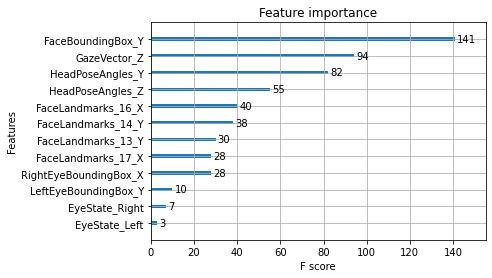

In [31]:
# import the plot_importance function to visualize the feature importance
from xgboost import plot_importance
plot_importance(model)
plt.show()

In [32]:
!pip install graphviz

<Figure size 864x864 with 0 Axes>

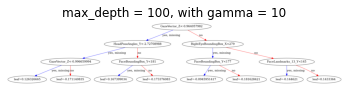

In [33]:
from xgboost import plot_tree
from matplotlib.pylab import rcParams

plt.figure(figsize=(12,12))
plot_tree(model, num_trees = 1)
plt.title("max_depth = 100, with gamma = 10")
plt.savefig("plot_tree_xgboost_norm", dpi = 300)

## 模型測試

In [34]:
# Test
# 測試一個答案全部為1的資料。
# df_test = pd.read_csv('/project/xt121-group5/scene2_data/test_data/2023-05-06 135830_c.csv')
df_test = pd.read_csv('/project/xt121-group5/scene2_data_01equal/larry/2023-05-01 232329.csv')
df_test = FaceLandmarksPreprocessing(df_test)
df_test = ReserveImportColumns(df_test, col_reserved)
# test, _ = data_preprocessing(df_test, train=False, sc=train_sc)

In [35]:
print(df_test.columns)
pred = model.predict(df_test)
print(pred.shape)
print(type(pred))

Index(['FaceBoundingBox_Y', 'FaceLandmarks_13_Y', 'FaceLandmarks_14_Y',
       'FaceLandmarks_16_X', 'FaceLandmarks_17_X', 'HeadPoseAngles_Y',
       'HeadPoseAngles_Z', 'EyeState_Left', 'EyeState_Right',
       'LeftEyeBoundingBox_Y', 'RightEyeBoundingBox_X', 'GazeVector_Z'],
      dtype='object')
(305,)
<class 'numpy.ndarray'>


In [36]:
print(pred)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1]


In [37]:
# Test
# 測試一個答案全部為0的資料。
# df_test = pd.read_csv('/project/xt121-group5/scene2_data/test_data/2023-05-06 135847_nc.csv')
df_test = pd.read_csv('/project/xt121-group5/scene2_data/test_data/2023-05-06 135847_nc.csv')
df_test = FaceLandmarksPreprocessing(df_test)
df_test = ReserveImportColumns(df_test, col_reserved)
# test, _ = data_preprocessing(df_test, train=False, sc=train_sc)

In [38]:
pred = model.predict(df_test)
print(pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


## 儲存模型

### 方法1. joblib

In [39]:
# Save model
import joblib
joblib.dump(model, './XGB_joblib_normalized_model')

# Load model
loaded_xgb_model = joblib.load('./XGB_joblib_normalized_model')
pred = loaded_xgb_model.predict(df_test)
print(pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


### 方法2. save_model

In [40]:
# Save model
model.save_model('XGB_normalized_6pos6neg_model.json')

# Load model
import xgboost as xgb
model_xgb = xgb.XGBRegressor()
model_xgb.load_model('XGB_normalized_6pos6neg_model.json')
pred = model_xgb.predict(df_test)
print(pred)

[1.03051485e-02 1.03051485e-02 3.88191058e-03 4.17602668e-03
 4.17602668e-03 1.03051485e-02 1.09183304e-02 4.17602668e-03
 1.17392829e-02 1.09183304e-02 9.58351605e-03 9.58351605e-03
 1.09183304e-02 5.27329138e-03 1.39626267e-03 1.65498641e-03
 1.88690913e-03 2.13174126e-03 1.99200609e-03 5.27329138e-03
 1.44944049e-03 1.44944049e-03 3.88191058e-03 3.88191058e-03
 3.88191058e-03 3.88191058e-03 3.88191058e-03 4.67029773e-03
 2.13048980e-03 4.42613754e-03 3.88191058e-03 3.88191058e-03
 4.42613754e-03 3.88191058e-03 3.88191058e-03 3.88191058e-03
 3.88191058e-03 3.88191058e-03 1.75997859e-03 9.58351605e-03
 9.02199070e-04 1.65498641e-03 1.65498641e-03 1.65498641e-03
 1.65498641e-03 1.65498641e-03 1.65498641e-03 1.48579420e-04
 7.49421073e-04 2.89617479e-03 1.65498641e-03 7.49421073e-04
 7.49421073e-04 1.61251242e-04 7.49421073e-04 1.65498641e-03
 1.61251242e-04 1.89354541e-04 4.38855849e-02 1.94573030e-02
 7.80221121e-03 4.38855849e-02 4.38855849e-02 7.80221121e-03
 6.34528929e-03 6.208774

In [41]:
import xgboost
xgboost.__version__

'0.90'

In [42]:
# Test
# 測試一個答案全部為0的資料。
data_path = '/project/xt121-group5/DAiSEE/0/1100131017.csv'
df_test = pd.read_csv(data_path)
df_test = FaceLandmarksPreprocessing(df_test)
df_test = ReserveImportColumns(df_test, col_reserved)
# test, _ = data_preprocessing(df_test, train=False, sc=train_sc)

pred = model.predict(df_test)
print(pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]


In [43]:
mean_a = pred.mean()
print(mean_a)

0.0


In [44]:
data_dir = '/project/xt121-group5/DAiSEE/0'

amount = 0
acc = 0
for dirname, _, filenames in os.walk(data_dir):
    for filename in filenames:
        if dirname.split('/')[-1] != 'test_data':
            #print(os.path.join(dirname, filename))
            testdata = os.path.join(dirname, filename)
            df_test = pd.read_csv(testdata)
            df_test = FaceLandmarksPreprocessing(df_test)
            df_test = ReserveImportColumns(df_test, col_reserved)
            # test, _ = data_preprocessing(df_test, train=False, sc=train_sc)
            pred = model.predict(df_test)
            mean_a = pred.mean()
            print(mean_a)
            amount += 1
            if mean_a < 0.5:
                acc += 1
print(f'Total acc: {acc / amount}')

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.03
0.0
0.6
0.0
0.0
0.0
0.0
0.26
0.0
0.0
0.0
0.4033333333333333
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0033333333333333335
0.0
0.0
0.06315789473684211
0.03666666666666667
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.30666666666666664
0.0
0.0
0.0
0.0
Total acc: 0.9830508474576272
